In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as io
from scipy.interpolate import interp1d
import scipy.signal as signal
from itertools import chain
from model.filter import filtfilt

from time import time
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 12, 8
matplotlib.rcParams.update({'font.size': 30})

def getconst(constant, **kwargs):
    return tf.constant(constant, dtype=tf.float32, **kwargs)

In [2]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, None], name='input')
A, B = np.random.randn(2, 30)
a = getconst(A)
b = getconst(B)

tf_filt = filtfilt(b, a, x)

In [3]:
def measure_tf(sample_list, A=A, B=B):
    res = []
    
    for i, sample in enumerate(sample_list):
        print('\r%d/%d'%(i, len(sample_list)), flush=True, end='')
        t = time()
        sess.run(tf_filt, {x:sample, a:A, b:B})
        res.append(time()-t)
    return np.array(res)

In [4]:
def measure_scipy(sample_list, A=A, B=B, batch=False):
    
    res = []
    if batch:
        for i, batch in enumerate(sample_list):
            print('\r%d/%d'%(i, len(sample_list)), flush=True, end='')
            t = time()
            for sample in batch:
                signal.filtfilt(B, A, sample.squeeze())
            res.append(time()-t)
        return np.array(res)
    
    for i, sample in enumerate(sample_list):
        print('\r%d/%d'%(i, len(sample_list)), flush=True, end='')
        t = time()
        signal.filtfilt(B, A, sample.squeeze())
        res.append(time()-t)
    return np.array(res)

# Single sample - Single filter run, with different sample lengths

In [5]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
lengths = np.linspace(100, 20000, 200, dtype=int)
lengths.sort()

sample_list = [np.random.randn(1, l) for l in lengths]
scp_time = measure_scipy(sample_list)
tf_time = measure_tf(sample_list)



199/200

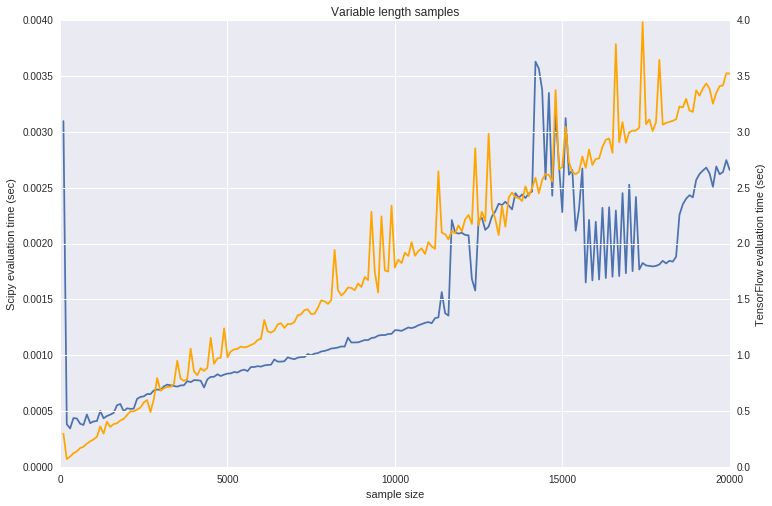

In [6]:
plt.plot(lengths, scp_time, label='SciPy.signal.filtfilt')
plt.title('Variable length samples')
plt.xlabel('sample size')
plt.ylabel('Scipy evaluation time (sec)')
ax2 = plt.gca().twinx()
ax2.plot(lengths, tf_time, color='orange')
ax2.set_ylabel('TensorFlow evaluation time (sec)')
#ax2.tick_params('y', colors='orange')

# Batch samples - Single filter run, with same length samples

199/200

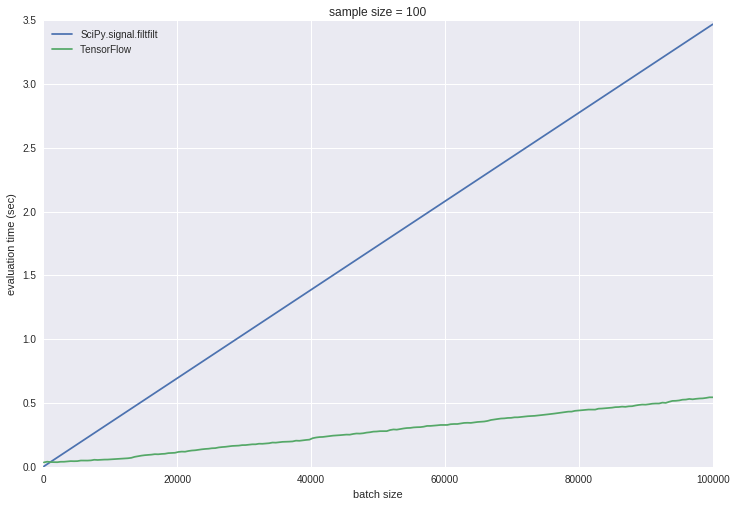

In [7]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
batch_size = np.linspace(100, 100000, 200, dtype=int)
lengths.sort()
sample_size = 100
sample_list = [np.random.randn(b, sample_size) for b in batch_size]
scp_batch_time = np.mean(scp_time/lengths) * sample_size * batch_size
#print('\n')
tf_batch_time_100 = measure_tf(sample_list)

plt.plot(batch_size, scp_batch_time, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_100, label='TensorFlow')
plt.title('sample size = 100')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 


199/200

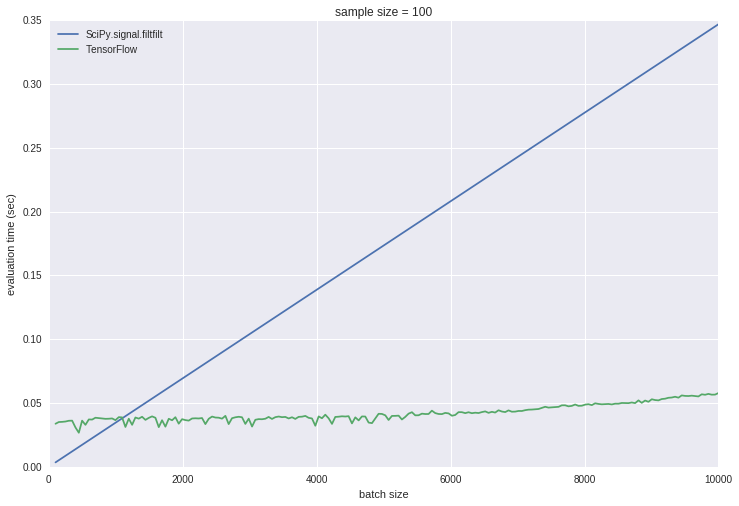

In [8]:
#lengths = list(set(np.logspace(2, 4, 100, dtype=int)*2))
batch_size = np.linspace(100, 10000, 200, dtype=int)
lengths.sort()
sample_size = 100
sample_list = [np.random.randn(b, sample_size) for b in batch_size]
scp_batch_time = np.mean(scp_time/lengths) * sample_size * batch_size
#print('\n')
tf_batch_time_100 = measure_tf(sample_list)

plt.plot(batch_size, scp_batch_time, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_100, label='TensorFlow')
plt.title('sample size = 100')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 


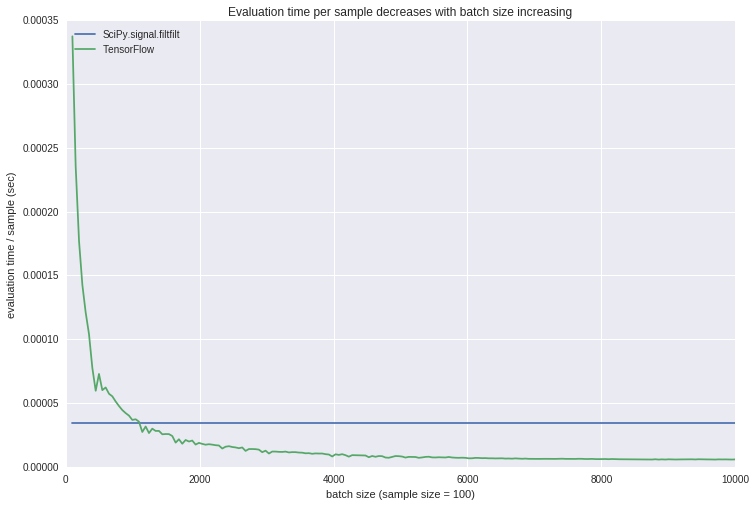

In [9]:
plt.plot(batch_size, scp_batch_time/batch_size, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_100/batch_size, label='TensorFlow')
plt.title('Evaluation time per sample decreases with batch size increasing')
plt.xlabel('batch size (sample size = 100)')
plt.ylabel('evaluation time / sample (sec)')
_ = plt.legend(loc=2) 

In [10]:
batch_size = np.linspace(100, 10000, 200, dtype=int)
sample_size = 1000
sample_list = [np.random.randn(b, sample_size) for b in batch_size]
scp_batch_time = np.mean(scp_time/lengths) * sample_size * batch_size
tf_batch_time_1000 = measure_tf(sample_list)

199/200

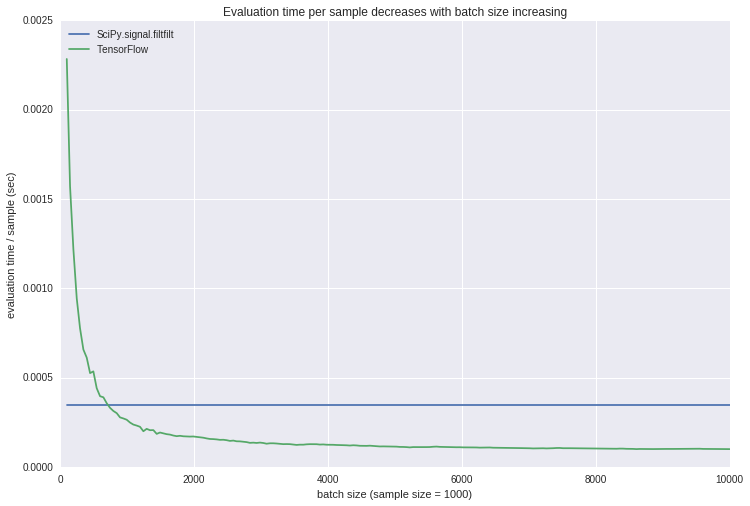

In [11]:
plt.plot(batch_size, scp_batch_time/batch_size, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_1000/batch_size, label='TensorFlow')
plt.title('Evaluation time per sample decreases with batch size increasing')
plt.xlabel('batch size (sample size = 1000)')
plt.ylabel('evaluation time / sample (sec)')
_ = plt.legend(loc=2) 

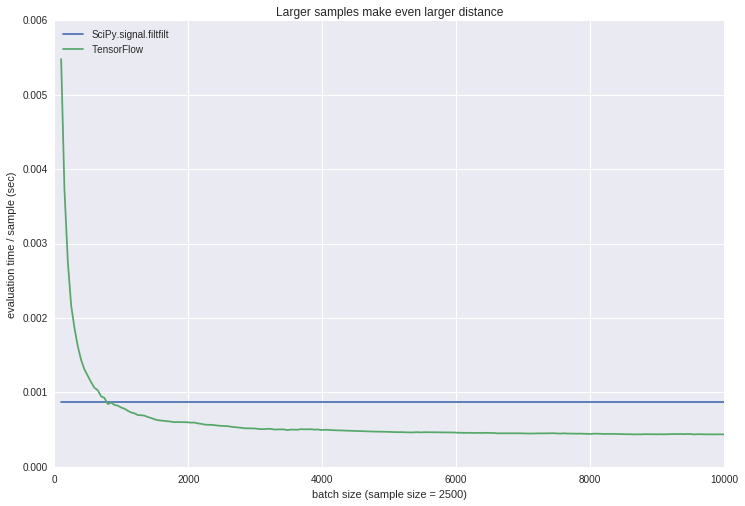

In [19]:
batch_size = np.linspace(100, 10000, 200, dtype=int)
sample_size = 2500
#sample_list = [np.random.randn(b, sample_size) for b in batch_size]
scp_batch_time = np.mean(scp_time/lengths) * sample_size * batch_size
tf_batch_time_2500 = measure_tf(sample_list)

plt.plot(batch_size, scp_batch_time/batch_size, label='SciPy.signal.filtfilt')
plt.plot(batch_size, tf_batch_time_2500/batch_size, label='TensorFlow')
plt.title('Larger samples make even larger distance')
plt.xlabel('batch size (sample size = 2500)')
plt.ylabel('evaluation time / sample (sec)')
_ = plt.legend(loc=2) 

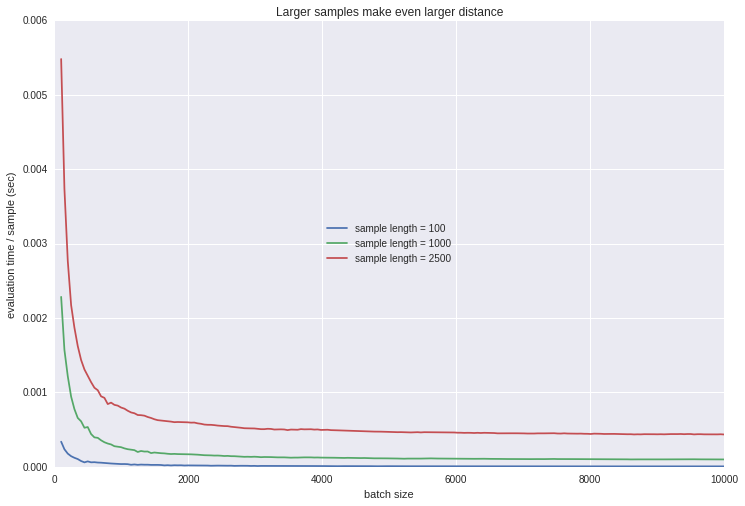

In [24]:
plt.plot(batch_size, tf_batch_time_100/batch_size, label='sample length = 100')
plt.plot(batch_size, tf_batch_time_1000/batch_size, label='sample length = 1000')
plt.plot(batch_size, tf_batch_time_2500/batch_size, label='sample length = 2500')
plt.title('Larger samples make even larger distance')
plt.xlabel('batch size')
plt.ylabel('evaluation time / sample (sec)')
_ = plt.legend(loc='center') 

In [25]:
def benchmark_sample_len(sam_len):
    batch_size = np.linspace(100, 10000, 200, dtype=int)
    sample_size = sam_len
    test_vals = np.random.randn(batch_size[-1], sample_size)
    sample_list = [test_vals[:b] for b in batch_size]
    return measure_tf(sample_list)


In [27]:
res = []
sample_lens = [100, 500, 1000, 2000, 3000, 4000, 5000]:
for lens in sample_lens
    res.append(benchmark_sample_len(lens))
    print('\n')

199/200

199/200

199/200

199/200

199/200

199/200

199/200



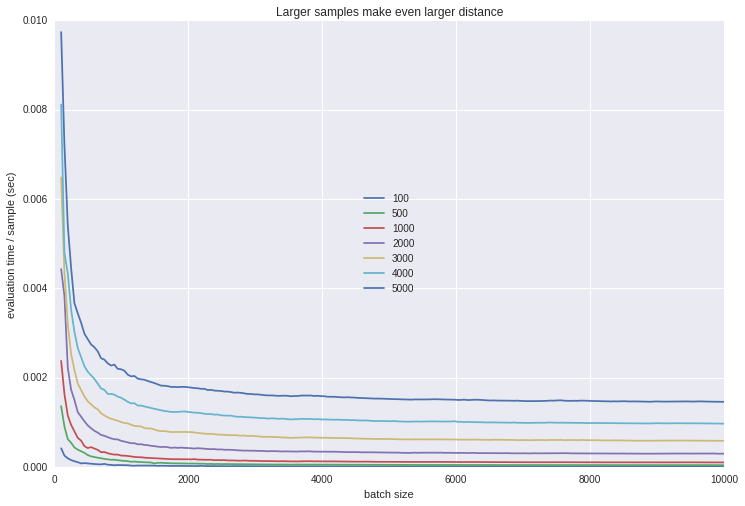

In [37]:
batch_size = np.linspace(100, 10000, 200, dtype=int)
for r, lens in zip(res, sample_lens):
    plt.plot(batch_size, r/batch_size, label=str(lens))
    
plt.title('Larger samples make even larger distance')
plt.xlabel('batch size')
plt.ylabel('evaluation time / sample (sec)')
_ = plt.legend(loc='center') 

In [14]:
tf_batch_time_LARGE_avg = np.mean(tf_batch_time_LARGE, axis=0)

/usr/lib64/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


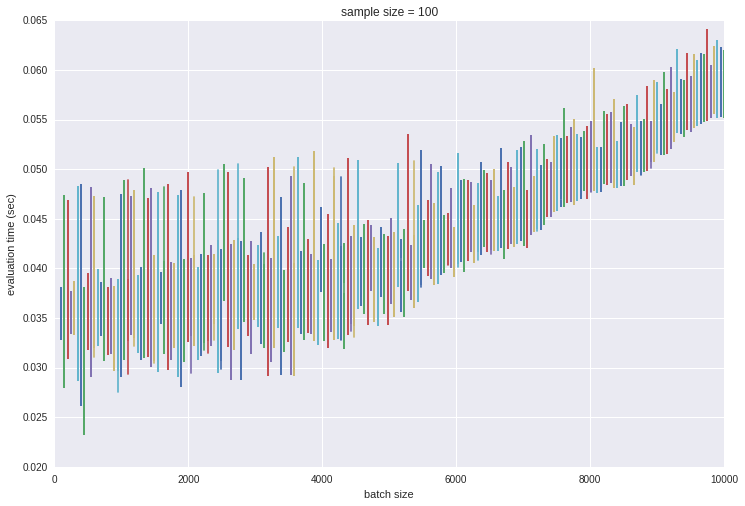

In [15]:
#plt.plot(batch_size, scp_batch_time, label='SciPy.signal.filtfilt')
plt.plot([batch_size]*20, tf_batch_time_LARGE)
plt.title('sample size = 100')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 


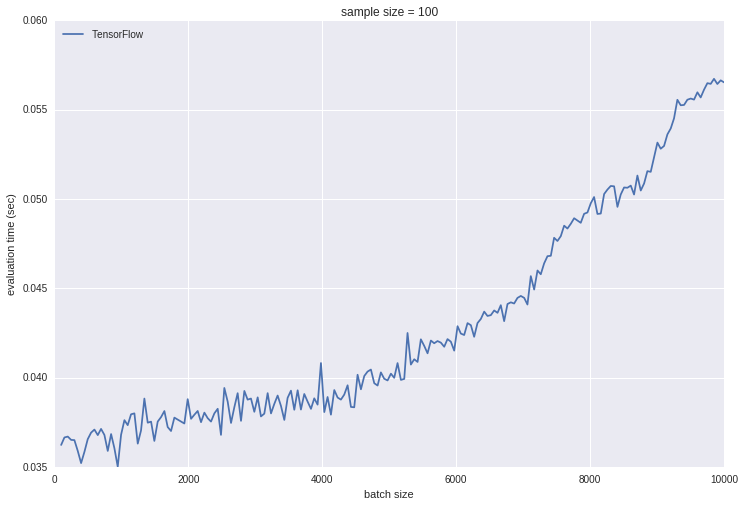

In [16]:
plt.plot(batch_size, tf_batch_time_LARGE_avg, label='TensorFlow')
plt.title('sample size = 100')
plt.xlabel('batch size')
plt.ylabel('evaluation time (sec)')
_ = plt.legend(loc=2) 
